![ewatercycle logo](https://raw.githubusercontent.com/eWaterCycle/ewatercycle/main/docs/examples/logo.png)

## Case study 4: Replace internal evaporation module of PCRGlobWB2.0 with external data source
This notebooks demonstrates how to use eWaterCycle to 'interfere' in a model. Every timestep, the evaporation of PCRGlobWB is 'corrected' to reflect the evaporation as measured by FLuxnet data. In this way, the model is forced by both precipitation and evaporation. Since we are only using one (point) measurement as 'the evaporation' of the entire basin, this (of course) leads to a rather different prediction for discharge. Which one is 'better' is, as always, in the eye of the beholder.

## Import statements
We'll be using the following modules

In [1]:
# This cell is only used to suppress some distracting output messages
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# eWaterCycle specific
import ewatercycle.analysis
import ewatercycle.models
import ewatercycle.observation.grdc
import ewatercycle.parameter_sets

In [3]:
# Calculations and plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Cartography (drawing maps)
from cartopy import crs
from cartopy import feature as cfeature

The cell below contains adjustable settings for the experiment. These can be adjusted, but of course only in so far as the available input data allows for it.

In [4]:
# the GRDC (see below) station number
grdc_station = "4147380"

# the start and the end of the experiment. Note that forcing data must be available for this period
experiment_start_date = "2002-01-01T00:00:00Z"
experiment_end_date = "2002-12-31T00:00:00Z"

# the parameter set used for the experiment. A number of ready made parameter sets for different models is 
# available in eWaterCycle, see the documentation
experiment_parameterset_name = 'pcrglobwb_merrimack_05min'

# the file containing the fluxnet observations
fluxnet_data_filename = "./externalData/FLX_US-Ha1_FLUXNET2015_SUBSET_DD_1991-2012_1-4.csv"

## Import GRDC observations

We will use GRDC station data to verify the model output. 
Read the GRDC data for the period of the experiment, for the station given above. If you are not on the SURF Researchcloud or the cartesius or Snellius supercomputers, follow the instructions about [download-observation-data](https://ewatercycle.readthedocs.io/en/latest/system_setup.html#download-observation-data) on our [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html#) documentation page. 

In [5]:
observations, metadata = ewatercycle.observation.grdc.get_grdc_data(
    grdc_station, start_time=experiment_start_date, end_time=experiment_end_date
)

grdc_latitude = metadata["grdc_latitude_in_arc_degree"]
grdc_longitude = metadata["grdc_longitude_in_arc_degree"]
discharge_data = observations.rename(columns={"streamflow": "GRDC"})
discharge_data.head()

GRDC station 4147380 is selected. The river name is: MERRIMACK RIVER.The coordinates are: (42.6459, -71.2984).The catchment area in km2 is: 12004.7. There are 0 missing values during 2002-01-01T00:00:00Z_2002-12-31T00:00:00Z at this station. See the metadata for more information.


,GRDC
time,
2002-01-01,56.067
2002-01-02,54.085
2002-01-03,48.988
2002-01-04,50.121
2002-01-05,47.572


Add columns for the data and fill them with NaN.
We will add data to these columns as we run the model experiments

In [6]:
discharge_data["reference"] = np.nan
discharge_data["experiment"] = np.nan
discharge_data.head()

,GRDC,reference,experiment
time,,,
2002-01-01,56.067,NaN,NaN
2002-01-02,54.085,NaN,NaN
2002-01-03,48.988,NaN,NaN
2002-01-04,50.121,NaN,NaN
2002-01-05,47.572,NaN,NaN


## Loading parameter set

In [7]:
experiment_parameterset = ewatercycle.parameter_sets.get_parameter_set(experiment_parameterset_name)
print(experiment_parameterset)

Parameter set
-------------
name=pcrglobwb_merrimack_05min
directory=/mnt/data/parameter-sets/pcrglobwb_global
config=/mnt/data/parameter-sets/pcrglobwb_global/merrimack_05min_era5.ini
doi=https://doi.org/10.5281/zenodo.1045339
target_model=pcrglobwb
supported_model_versions={'setters'}


## Setting up the model objects

Start up a container for PCRGlob for the reference run and initialize using the setting file

In [8]:
reference = ewatercycle.models.PCRGlobWB(version="setters", parameter_set=experiment_parameterset)

reference_config, reference_dir = reference.setup(
    start_date = experiment_start_date, 
    end_date = experiment_end_date)

print(reference_config, reference_dir)

reference.initialize(reference_config)

Running /mnt/data/singularity-images/ewatercycle-pcrg-grpc4bmi_setters.sif singularity container on port 58169
/home/rhut/technicalPaperExampleNotebooks/ewatercycle_output/pcrglobwb_20210923_133943/pcrglobwb_ewatercycle.ini /home/rhut/technicalPaperExampleNotebooks/ewatercycle_output/pcrglobwb_20210923_133943


Start up a container for PCRGlob for the experiment run and initialize using the setting file

In [9]:
experiment = ewatercycle.models.PCRGlobWB(version="setters", parameter_set=experiment_parameterset)

experiment_config, experiment_dir = experiment.setup(
    start_date = experiment_start_date, 
    end_date = experiment_end_date)

print(experiment_config, experiment_dir)

experiment.initialize(experiment_config)

Running /mnt/data/singularity-images/ewatercycle-pcrg-grpc4bmi_setters.sif singularity container on port 38209
/home/rhut/technicalPaperExampleNotebooks/ewatercycle_output/pcrglobwb_20210923_134131/pcrglobwb_ewatercycle.ini /home/rhut/technicalPaperExampleNotebooks/ewatercycle_output/pcrglobwb_20210923_134131


# Importing evaporation data from Fluxnet

Read the csv file downloaded from [https://fluxnet.org/](https://fluxnet.org/) into a dataframe.

In [10]:
fluxnet_rawdata = pd.read_csv(fluxnet_data_filename)
fluxnet_rawdata["Datetime"] = pd.to_datetime(fluxnet_rawdata["TIMESTAMP"], format="%Y%m%d")
fluxnet_rawdata = fluxnet_rawdata.set_index("Datetime")

Select evaporation measured as latent heat flux from fluxnetdata
and rewrite evaporation from latent heat flux to m/day

In [11]:
fluxnet_evaporation = (
    fluxnet_rawdata["LE_F_MDS"] / (2.43 * 1000000) * 6772 ** 2 / (3600 * 24)
)

We will apply a correction to the model state based on this fluxnet data. To be able to better read the main loop of the experiment, this is done by calling the function below. Note that `model` in this function is a fully initialized hydrological model object. 

In [12]:
def apply_fluxnet_correction(model, fluxnet_evap):
    """Adjust soil moisture and channel storage based on measured evaporation."""

    # Read out model data
    land_surface_evaporation = model.get_value_as_xarray("land_surface_evaporation")
    bare_soil_evaporation = model.get_value_as_xarray("bare_soil_evaporation")
    upper_soil_storage = model.get_value_as_xarray("upper_soil_storage")
    upper_soil_saturation_degree = model.get_value_as_xarray(
        "upper_soil_saturation_degree"
    )
    channel_storage = model.get_value_as_xarray("channel_storage")

    # Determine a correction factor by comparing mean land surface evaporation to fluxnet evaporation
    time = land_surface_evaporation.time.dt.strftime("%Y-%m-%d").item()
    correction_factor = (fluxnet_evap[time] / land_surface_evaporation.mean()).item()

    # Apply the correction factor to bare soil evaporation in the model
    corrected_bare_soil_evaporation = bare_soil_evaporation * correction_factor
    evaporation_adjustment = corrected_bare_soil_evaporation - bare_soil_evaporation

    # Apply the same absolute correction to upper soil storage
    corrected_upper_soil_storage = (
        upper_soil_storage - evaporation_adjustment
    )  

    # Determine whether there is an excess or deficit
    maximum_upper_soil_storage = (1 / upper_soil_saturation_degree) * upper_soil_storage
    excess = corrected_upper_soil_storage > maximum_upper_soil_storage
    deficit = corrected_upper_soil_storage < 0

    # Where there is an excess, water will be added to the channel
    updated_channel_storage = channel_storage + (
        corrected_upper_soil_storage - maximum_upper_soil_storage
    )
    channel_storage = updated_channel_storage.where(excess, other=channel_storage)
    corrected_upper_soil_storage = maximum_upper_soil_storage.where(
        excess, other=corrected_upper_soil_storage
    )

    # Where there is a deficit, water will be taken from the channel
    updated_channel_storage = (
        channel_storage + corrected_upper_soil_storage
    )  # (note that the last term is always negative here)
    channel_storage = updated_channel_storage.where(deficit, other=channel_storage)
    corrected_upper_soil_storage = corrected_upper_soil_storage.where(~deficit, other=0)

    # Convert storage to saturation
    corrected_upper_soil_saturation_degree = (
        corrected_upper_soil_storage / maximum_upper_soil_storage
    )
    corrected_upper_soil_saturation_degree = (
        corrected_upper_soil_saturation_degree.fillna(upper_soil_saturation_degree)
    )

    # Update the running model
    model.set_value("channel_storage", channel_storage.values.flatten())
    model.set_value(
        "upper_soil_saturation_degree",
        corrected_upper_soil_saturation_degree.values.flatten(),
    )

## Running the experiment
With all pieces in place, we can now start to run the actual experiment. Since both models (reference and experiment) do not interact, they can be run in separate loops and (ideally) this should be done in parallel.

In [13]:
print(f"Running Reference Model Run", flush=True)
while reference.time < reference.end_time:

    # Update the model (takes a few seconds per timestep)
    reference.update()

    # Track discharge at station location
    discharge_at_station = reference.get_value_at_coords(
        "discharge", lon=[grdc_longitude], lat=[grdc_latitude]
    )

    # Add the discharge to the dataframe
    time = reference.time_as_datetime.date().strftime(
        "%Y-%m-%d"
    )  # needs to match the time format of the dataframe
    discharge_data["reference"][time] = discharge_at_station

    # Show progress
    print(f"Current time: {time}", end="\r")

print("\nDone")

Running Reference Model Run
Current time: 2002-12-31
Done


In [14]:
print(f"Running Experiment Model Run", flush=True)
while experiment.time < experiment.end_time:

    # Update the model (takes a few seconds per timestep)
    experiment.update()

    # Apply a correction based on fluxnet data
    apply_fluxnet_correction(experiment, fluxnet_evaporation)

    # Track discharge at station location
    discharge_at_station = experiment.get_value_at_coords(
        "discharge", lon=[grdc_longitude], lat=[grdc_latitude]
    )

    # Add the discharge to the dataframe
    time = experiment.time_as_datetime.date().strftime(
        "%Y-%m-%d"
    )  # needs to match the time format of the dataframe
    discharge_data["experiment"][time] = discharge_at_station

    # Show progress
    print(
        f"Current time: {time}", end="\r"
    )  # "\r" clears the output before printing the next timestamp

print("\nDone")

Running Experiment Model Run
Current time: 2002-12-31
Done


## Plot the results

Show a map of the final time step:

/opt/conda/envs/ewatercycle/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
/opt/conda/envs/ewatercycle/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
/opt/conda/envs/ewatercycle/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip


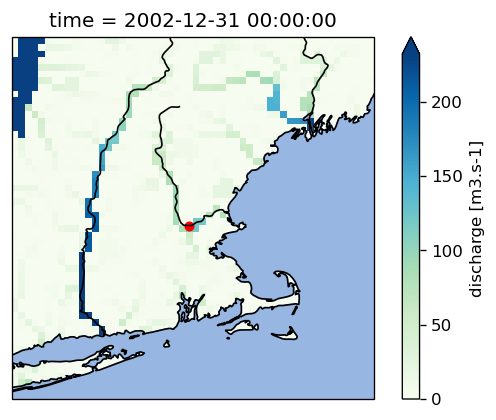

In [15]:
# Use matplotlib to make the figure slightly nicer
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())

# Plotting the model field is a one-liner
reference.get_value_as_xarray("discharge").plot(ax=ax, cmap="GnBu", robust=True)

# Also plot the station location
ax.scatter(grdc_longitude, grdc_latitude, s=25, c="r")

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.add_feature(cfeature.RIVERS, zorder=2, color="k")
ax.coastlines(zorder=3)

fig.savefig(
    f"figures/Case4_ForcePCRGlobWithAdditionalDataMap", bbox_inches="tight", dpi=300
)

Plot the time series of discharge that we have traced

(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

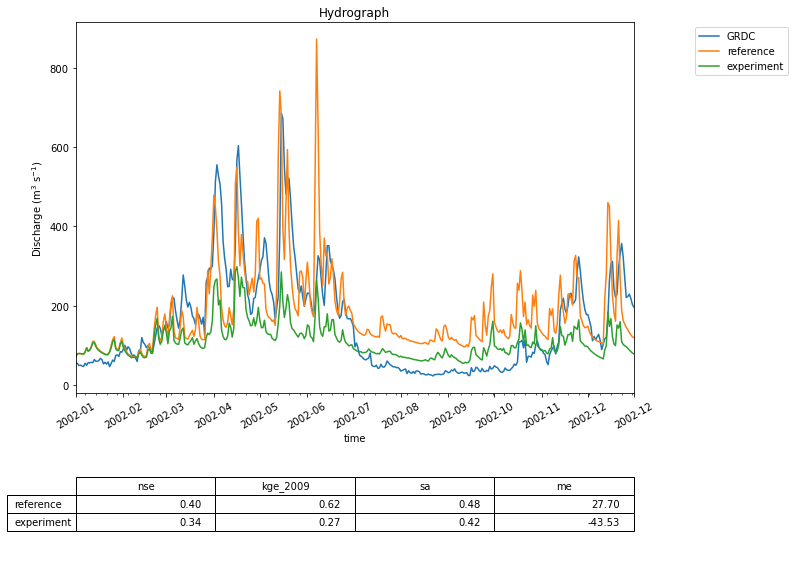

In [16]:
ewatercycle.analysis.hydrograph(discharge_data, reference="GRDC", filename="figures/Case4_ForcePCRGlobWithAdditionalDataHydrograph")

### Clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [17]:
reference.finalize()
experiment.finalize()